In [18]:
import numpy as np
import scipy as sc
import pandas as pd
import scipy.stats as stats
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import lifelines
from lifelines import KaplanMeierFitter

In [2]:
# read data
original_data = pd.read_csv('Transplant_10H0154.csv')

# data.describe() # used to see count of data to cut the csv into the parts where there was data
new = original_data.head(35) # cut data to 35, which was count returned in fixed_data.describe()
n = 35

# remove unnecessary white space at beginning and end of column headers
for col in new.columns:
    new = new.rename(columns={col:col.title().strip()}) # makes each word capitalized, removes leading and trailing spaces

new.columns = new.columns.str.replace('  ', ' ') # remove double spaces

# remove unnecessary white space at beginning and end of values
for row_idx in range(0, new.shape[0]):
    for col_idx in range(0, new.shape[1]):
        if new.dtypes[col_idx] == 'object':
            new.iloc[row_idx, col_idx] = str(new.iloc[row_idx, col_idx]).strip()
            new.iloc[row_idx, col_idx] = new.iloc[row_idx, col_idx].replace('  ', ' ')
            new.iloc[row_idx, col_idx] = new.iloc[row_idx, col_idx].title()
            
# for col in new.columns:
#     print(col)

In [3]:
# read old protocol data
original_data_old = pd.read_csv('Protocol-99-H-0050B-data.csv')

# data.describe() # used to see count of data to cut the csv into the parts where there was data
old = original_data_old.head(59) # cut data to 59, which was count returned in data.describe()

# remove unnecessary white space at beginning and end of column headers
for col in old.columns:
    old = old.rename(columns={col:col.title().strip()}) # makes each word capitalized, removes leading and trailing spaces

old.columns = old.columns.str.replace('  ', ' ') # remove double spaces

# remove unnecessary white space at beginning and end of values
for row_idx in range(0, old.shape[0]):
    for col_idx in range(0, old.shape[1]):
        if old.dtypes[col_idx] == 'object':
            old.iloc[row_idx, col_idx] = str(old.iloc[row_idx, col_idx]).strip()
            old.iloc[row_idx, col_idx] = old.iloc[row_idx, col_idx].replace('  ', ' ')
            old.iloc[row_idx, col_idx] = old.iloc[row_idx, col_idx].title()
# print('Size: ', old.shape)
n_old = old.shape[0]
# for column in old.columns:
#     print(column)

In [4]:
def round5(num):
    """
    Round num up to the nearest multiple of 5
    Inputs:
    - num: a number to round up to the nearest multiple of 5
    """
    final = 5 * round(num / 5)
    if final < num:
        final += 5
    return final

def round2(num):
    """
    Round num up to the nearest multiple of 2
    Inputs:
    - num: a number to round up to the nearest multiple of 2
    """
    final = 2 * round(num / 2)
    if final < num:
        final += 2
    return final

In [5]:
def cumulative_incidence_curve(dataset, n, figurename, xname, yname, title):
    """
    Draws a cumulative incidence curve from the given input dataset
    Inputs:
    - dataset: the data that is used to draw the curve (e.g. a df column or a series)
    - n: number--sample size
    - figurename: a str that's the name of the figure to label plt.figure()
    - xname: a str that's the label of x axis
    - yname: a str that's the label of y axis
    - title: a str that's the title of plot
    Outputs: 
    - a cumulative incidence plot
    """
    dataset_sorted = dataset.sort_values() # sort days data from least to greatest
    cumulative_incidence = [0]
    days_lst = [0]
    prev = 0
    for days in dataset_sorted:
        if days != prev: 
            # make new point under the next point to create the staircase look
            days_lst.append(days)
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1])
            # add new point
            days_lst.append(days)  # add this number of days to x values
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1] + 1 / n)
        if days == prev:
            cumulative_incidence[len(cumulative_incidence) - 1] += 1 / n
        # add proportion to cumulative incidence
        prev = days
    # print(cumulative_incidence)
    # print(days_lst)
    # if (0,0) is not a point in the plot, add it
    days_lst.insert(0,0)
    cumulative_incidence.insert(0,0)

    plt.figure(figurename)
    plt.plot(days_lst, cumulative_incidence)

    plt.xlabel(xname, fontsize=12)
    plt.ylabel(yname, fontsize=12)
    plt.title(title, fontsize=14)
    # Limit X and Y ranges
    plt.xlim(0, round5(dataset.max()))
    plt.ylim(0, 1)
    plt.show()

In [6]:
def cumulative_incidence_curve2(dataset, n, dataset2, n2, figurename, xname, yname, title, legend):
    """
    Draws w cumulative incidence curves on the same plot from the given input datasets
    Inputs:
    - dataset: the data that is used to draw the curve (e.g. a df column or a series)
    - n: number--sample size
    - figurename: a str that's the name of the figure to label plt.figure()
    - xname: a str that's the label of x axis
    - yname: a str that's the label of y axis
    - title: a str that's the title of plot
    - legend
    Outputs: 
    - a cumulative incidence plot
    """
    plt.figure(figurename)
    # --- first dataset ---
    dataset_sorted = dataset.sort_values() # sort days data from least to greatest
    cumulative_incidence = [0]
    days_lst = [0]
    prev = 0
    for days in dataset_sorted:
        if days != prev: 
            # make new point under the next point to create the staircase look
            days_lst.append(days)
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1])
            # add new point
            days_lst.append(days)  # add this number of days to x values
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1] + 1 / n)
        if days == prev:
            cumulative_incidence[len(cumulative_incidence) - 1] += 1 / n
        # add proportion to cumulative incidence
        prev = days
    days_lst.insert(0,0)
    cumulative_incidence.insert(0,0)

    plt.plot(days_lst, cumulative_incidence)

    # --- second dataset ---
    dataset_sorted2 = dataset2.sort_values() # sort days data from least to greatest
    cumulative_incidence2 = [0]
    days_lst2 = [0]
    prev2 = 0
    for days2 in dataset_sorted2:
        if days2 != prev2: 
            # make new point under the next point to create the staircase look
            days_lst2.append(days2)
            cumulative_incidence2.append(cumulative_incidence2[len(cumulative_incidence2) - 1])
            # add new point
            days_lst2.append(days2)  # add this number of days to x values
            cumulative_incidence2.append(cumulative_incidence2[len(cumulative_incidence2) - 1] + 1 / n2)
        if days2 == prev2:
            cumulative_incidence2[len(cumulative_incidence2) - 1] += 1 / n2
        # add proportion to cumulative incidence
        prev2 = days2
    days_lst2.insert(0,0)
    cumulative_incidence2.insert(0,0)
    
    plt.plot(days_lst2, cumulative_incidence2)

    plt.xlabel(xname, fontsize=12)
    plt.ylabel(yname, fontsize=12)
    plt.title(title, fontsize=14)
#     plt.legend(legend)

    # Limit X and Y ranges
    plt.xlim(0, max(round5(dataset.max()), round5(dataset2.max())))
    plt.ylim(0, 1)
    plt.savefig(figurename, dpi=1200)
    plt.show()

In [7]:
# survival curve
def survival_curve(dataset, n, figurename, xname, yname, title):
    """
    Creates a survival curve based on input data
    Inputs:
    - dataset: the data that is used to draw the curve (e.g. a df column or a series)
    - n: number of patients total
    - figurename: a str that's the name of the figure to label plt.figure()
    - xname: a str that's the label of x axis
    - yname: a str that's the label of y axis
    - title: a str that's the title of plot
    Outputs: 
    - a survival curve
    """
    dataset_sorted = dataset.sort_values() # sort days data from least to greatest
    cumulative_incidence = [1]
    days_lst = [0]
    prev = 0
    for days in dataset_sorted:
        if days != prev: 
            # make new point under the next point to create the staircase look
            days_lst.append(days)
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1])
            # add new point
            days_lst.append(days)  # add this number of days to x values
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1] - 1 / n)
        if days == prev:
            cumulative_incidence[len(cumulative_incidence) - 1] -= 1 / n
        # add proportion to cumulative incidence
        prev = days
    # print(cumulative_incidence)
    # print(days_lst)

    plt.figure(figurename)
    plt.plot(days_lst, cumulative_incidence)

    plt.xlabel(xname, fontsize=12)
    plt.ylabel(yname, fontsize=12)
    plt.title(title, fontsize=14)
    # Limit X and Y ranges
    plt.xlim(0, round2(dataset.max()))
    plt.ylim(0, 1)
    plt.show()

In [8]:
def survival_curve2(dataset, n, dataset2, n2, figurename, xname, yname, title, legend):
    """
    Creates 2 survival curves on the same plot based on input datasets
    Inputs:
    - dataset: the data that is used to draw the curve (e.g. a df column or a series)
    - n: number of patients total
    - figurename: a str that's the name of the figure to label plt.figure()
    - xname: a str that's the label of x axis
    - yname: a str that's the label of y axis
    - title: a str that's the title of plot
    Outputs: 
    - a survival curve
    """
    # dataset 1
    dataset_sorted = dataset.sort_values() # sort days data from least to greatest
    cumulative_incidence = [1]
    days_lst = [0]
    prev = 0
    for days in dataset_sorted:
        if days != prev: 
            # make new point under the next point to create the staircase look
            days_lst.append(days)
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1])
            # add new point
            days_lst.append(days)  # add this number of days to x values
            cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1] - 1 / n)
        if days == prev:
            cumulative_incidence[len(cumulative_incidence) - 1] -= 1 / n
        # add proportion to cumulative incidence
        prev = days
    # print(cumulative_incidence)
    # print(days_lst)

    plt.figure(figurename)
    plt.plot(days_lst, cumulative_incidence)

    # dataset 2
    dataset_sorted2 = dataset2.sort_values() # sort days data from least to greatest
    cumulative_incidence2 = [1]
    days_lst2 = [0]
    prev2 = 0
    for days2 in dataset_sorted2:
        if days2 != prev2: 
            # make new point under the next point to create the staircase look
            days_lst2.append(days2)
            cumulative_incidence2.append(cumulative_incidence2[len(cumulative_incidence2) - 1])
            # add new point
            days_lst2.append(days2)  # add this number of days to x values
            cumulative_incidence2.append(cumulative_incidence2[len(cumulative_incidence2) - 1] - 1 / n2)
        if days2 == prev2:
            cumulative_incidence2[len(cumulative_incidence2) - 1] -= 1 / n2
        # add proportion to cumulative incidence
        prev2 = days2

    plt.plot(days_lst2, cumulative_incidence2)
    
    plt.xlabel(xname, fontsize=12)
    plt.ylabel(yname, fontsize=12)
    plt.title(title, fontsize=14)
#     plt.legend(legend)
    
    # Limit X and Y ranges
    plt.xlim(0, max(round2(dataset.max()), round2(dataset2.max())))
    plt.ylim(0, 1)
    
    plt.savefig(figurename, dpi=1200)

    plt.show()

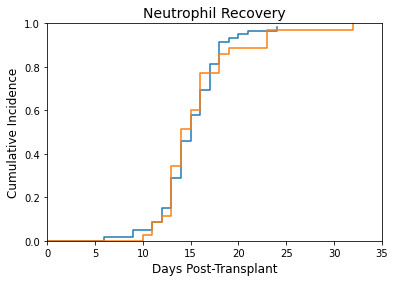

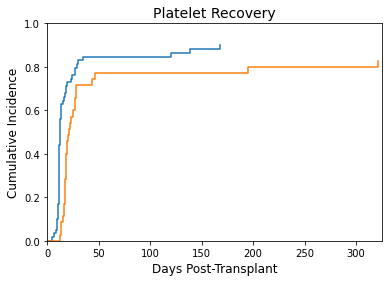

In [9]:
# # Neutrophil recovery for new protocol
# old_neutrophil = cumulative_incidence_curve(new['Days To Neutrophil Recovery'], 35, 'New Neutrophil Recovery', 'Days', 'Cumulative Incidence', 'Days to Neutrophil Recovery (New)')
# # Platelet recovery for new protocol
# old_platelet = cumulative_incidence_curve(new['Days To Platelet Recovery Count Of 20'], 35, 'New Platelet Recovery', 'Days', 'Cumulative Incidence', 'Days to Platelet Recovery (New)')
# # Neutrophil recovery for old protocol
# new_neutrophil = cumulative_incidence_curve(old['Neutrophil_Recovery_Day'], 59, 'Old Neutrophil Recovery', 'Days', 'Cumulative Incidence', 'Days to Neutrophil Recovery (Old)')
# # Platelet recovery for old protocol
# new_platelet = cumulative_incidence_curve(old['Platelet_Recovery_Day'], 59, 'Old Platelet Recovery', 'Days', 'Cumulative Incidence', 'Days to Platelet Recovery (Old)')

# two plots together neutrophil
cumulative_incidence_curve2(old['Neutrophil_Recovery_Day'], 59, new['Days To Neutrophil Recovery'], 35, 'Days to Neutrophil Recovery', 'Days Post-Transplant', 'Cumulative Incidence', 'Neutrophil Recovery', ['Historical Unmanipulated', 'Partial T-cell Depleted'])
# two plots together platelet
cumulative_incidence_curve2(old['Platelet_Recovery_Day'], 59, new['Days To Platelet Recovery Count Of 20'], 35, 'Days to Platelet Recovery', 'Days Post-Transplant', 'Cumulative Incidence', 'Platelet Recovery', ['Historical Unmanipulated', 'Partial T-cell Depleted'])

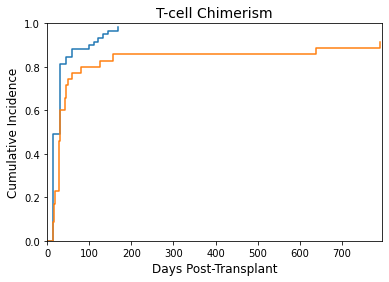

In [10]:
# # T-CELL CHIMERISM
# cumulative_incidence_curve(old['Days_To_Full_Donor_T-Chim'], 59, 'Old T Cell Chimerism', 'Days', 'Cumulative Incidence', 'Days to 95% T-Cell Chimerism (Old)')
# cumulative_incidence_curve(new['Time (Days) To >= 95%Tcell T Cell Chimerism'], 35, 'New T Cell Chimerism', 'Days', 'Cumulative Incidence', 'Days to 95% T-Cell Chimerism (New)')
# together
cumulative_incidence_curve2(old['Days_To_Full_Donor_T-Chim'], 59, new['Time (Days) To >= 95%Tcell T Cell Chimerism'], 35, 'Days to T-cell Chimerism', 'Days Post-Transplant', 'Cumulative Incidence', 'T-cell Chimerism', ['Historical Unmanipulated', 'Partial T-cell Depleted'])

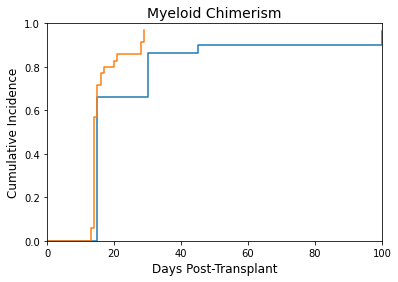

In [11]:
# MYELOID CHIMERISM
# remove largest value from old myeloid chimerism
oldmchim_max = old['Days_To_Full_Donor_M-Chim'].max()
oldmchim = []
for patient in old.index:
    if old.at[patient, 'Days_To_Full_Donor_M-Chim'] < oldmchim_max:
        oldmchim.append(old.at[patient, 'Days_To_Full_Donor_M-Chim'])
oldmchim = pd.Series(oldmchim)

# while len(oldmchim) < 59:
#     oldmchim.append(0)
# test = pd.DataFrame()
# test[0] = old['Days_To_Full_Donor_M-Chim']
# test[1] = oldmchim
# print(test)

# cumulative_incidence_curve(oldmchim, 59, 'Old Myeloid Chimerism', 'Days', 'Cumulative Incidence', 'Days to 95% Myeloid Chimerism (Old)')

# cumulative_incidence_curve(new['Time (Days) To >= 95% Myeloid Chimerism'], 35, 'New Myeloid Chimerism', 'Days', 'Cumulative Incidence', 'Days to 95% Myeloid Chimerism (New)')
cumulative_incidence_curve2(oldmchim, 59, new['Time (Days) To >= 95% Myeloid Chimerism'], 35, 'Days to Myeloid Chimerism', 'Days Post-Transplant', 'Cumulative Incidence', 'Myeloid Chimerism', ['Historical Unmanipulated', 'Partial T-cell Depleted'])

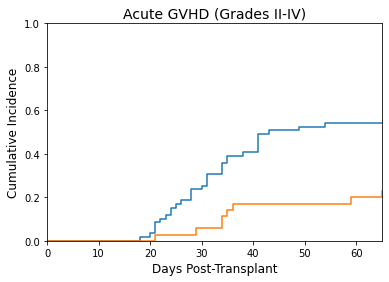

In [12]:
# old_agvhd
# for patient in old.index:
#     if old.at[patient, 'Acute_Gvhd_Grade2To4'] == 0:
old_agvhd = old['Acute_Gvhd_Grade2To4_Days'][old['Acute_Gvhd_Grade2To4_Days'].isin([0]) == False]
new_agvhd = new['Acute Gvhd By Post Transplant Day'][new['Acute Gvhd Grade'] > 1].dropna()
# old_cgvhd = old['Cgvhdday'][old['Cgvhdday'].isin([0]) == False]
# print(new_agvhd)
        
# cumulative_incidence_curve2(old_agvhd, 59, new_agvhd, 35, 'Development of Acute GVHD', 'Days Post-Transplant', 'Cumulative Incidence', 'Development of Acute GVHD', ['Historical Unmanipulated', 'Partial T-cell Depleted'])

n = 59
plt.figure('Development of Acute GVHD')
# --- first dataset ---
old_agvhd_sorted = old_agvhd.sort_values() # sort days data from least to greatest
cumulative_incidence = [0]
days_lst = [0]
prev = 0
for days in old_agvhd_sorted:
    if days != prev: 
        # make new point under the next point to create the staircase look
        days_lst.append(days)
        cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1])
        # add new point
        days_lst.append(days)  # add this number of days to x values
        cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence) - 1] + 1 / n)
    if days == prev:
        cumulative_incidence[len(cumulative_incidence) - 1] += 1 / n
    # add proportion to cumulative incidence
    prev = days
days_lst.insert(0,0)
cumulative_incidence.insert(0,0)
days_lst.append(65)
cumulative_incidence.append(cumulative_incidence[len(cumulative_incidence)-1])

plt.plot(days_lst, cumulative_incidence)

# --- second dataset ---
n2 = 35
new_agvhd_sorted = new_agvhd.sort_values() # sort days data from least to greatest
cumulative_incidence2 = [0]
days_lst2 = [0]
prev2 = 0
for days2 in new_agvhd_sorted:
    if days2 != prev2: 
        # make new point under the next point to create the staircase look
        days_lst2.append(days2)
        cumulative_incidence2.append(cumulative_incidence2[len(cumulative_incidence2) - 1])
        # add new point
        days_lst2.append(days2)  # add this number of days to x values
        cumulative_incidence2.append(cumulative_incidence2[len(cumulative_incidence2) - 1] + 1 / n2)
    if days2 == prev2:
        cumulative_incidence2[len(cumulative_incidence2) - 1] += 1 / n2
    # add proportion to cumulative incidence
    prev2 = days2
days_lst2.insert(0,0)
cumulative_incidence2.insert(0,0)
    
plt.plot(days_lst2, cumulative_incidence2)

plt.xlabel('Days Post-Transplant', fontsize=12)
plt.ylabel('Cumulative Incidence', fontsize=12)
plt.title('Acute GVHD (Grades II-IV)', fontsize=14)
# plt.legend(['Historical Unmanipulated', 'Partial T-cell Depleted'])

# Limit X and Y ranges
plt.xlim(0, max(round5(old_agvhd.max()), round5(new_agvhd.max())))
plt.ylim(0, 1)
plt.savefig('Development of Acute GVHD', dpi=1200)
plt.show()

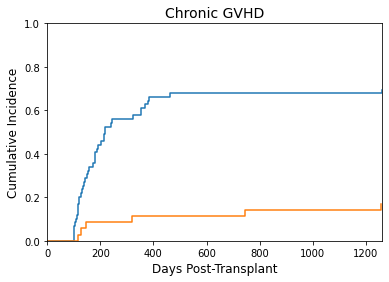

In [15]:
# OCCURENCE OF CHRONIC GVHD
# old_cgvhd = pd.Series(old['Cgvhdday'])
old_cgvhd = old['Cgvhdday'][old['Cgvhdday'].isin([0]) == False]
# df[df.column_name.isin(values) == False]
# cumulative_incidence_curve(old_cgvhd, 59, 'Old GVHD', 'Days to Develop cGVHD', 'Cumulative Incidence', 'Days to  Develop cGVHD (Old)')
# cumulative_incidence_curve(new['Chronic Gvhd By Post Transplant Day'], 35, 'New GVHD', 'Days to Develop cGVHD', 'Cumulative Incidence', 'Days to  Develop cGVHD (New)')

# together
cumulative_incidence_curve2(old_cgvhd, 59, new['Chronic Gvhd By Post Transplant Day'], 35, 'Development of Chronic GVHD', 'Days Post-Transplant', 'Cumulative Incidence', 'Chronic GVHD', ['Historical Unmanipulated', 'Partial T-cell Depleted'])

In [19]:
# survival new

from datetime import datetime

new_df = pd.DataFrame()

time_new = [] # years
event_new = [] # 1 = death
for patient in new.index:
    if new.at[patient, 'Death On Protocol'] == 'Yes':
        event_new.append(1)
        time_new.append(new.at[patient, 'Survival Post Transplant Day (In Case Of Death)'] / 365)
    else:
        event_new.append(0)
        # find time post-transplant
        dateoftransplant = new.at[patient, 'Date Of Transplant']
        components = dateoftransplant.split('/')
        
        # standardize times
        # update all instances of mm to be m
        if len(components[0][0]) == '0':
            components[0] = components[0][1]
        # update all instance of dd to be d
        if len(components[1][0]) == '0':
            components[1] = components[1][1]
        # update all instances of yy to be yyyy
        if len(components[2]) == 2:
            # if year is < 23 (since rn is year 2022), add 20 to the start. Otherwise, add 19 to the start
            if int(components[2]) < 23:
                components[2] = "20" + components[2]
            else:
                components[2] = "19" + components[2]
        dateoftransplant = components[0] + '/' + components[1] + '/' + components[2]
                
        tempfollowupdate = '5/1/2022'
        # ^ I didn't know when the last date of followup was; arbitrarily used this date as last date of followup
        
        daysinbetween = datetime.strptime(tempfollowupdate,"%m/%d/%Y") - datetime.strptime(dateoftransplant,"%m/%d/%Y")
        time_new.append(int(daysinbetween.days) / 365)
        
new_df['time'] = time_new
new_df['event'] = event_new

T_new = new_df['time']
E_new = new_df['event']
kmf = KaplanMeierFitter()
kmf.fit(T_new, event_observed=E_new)


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 35 total observations, 30 right-censored observations>

In [20]:
# new survival function
kmf.survival_function_

,KM_estimate
timeline,
0.000000,1.000000
0.071233,0.971429
0.104110,0.942857
0.106849,0.914286
0.126027,0.885714
0.394521,0.885714
0.473973,0.885714
0.810959,0.885714
0.876712,0.885714


(0.0, 5.0)

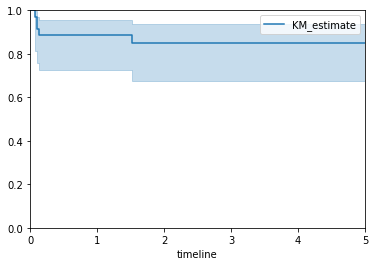

In [22]:
# new survival curve
new_surv = kmf.plot_survival_function()
new_surv.set_ylim(0,1)
new_surv.set_xlim(0,5)

In [23]:
# survival old
time_old = []
event_old = []
for patient in range(0, 59):
    time_old.append(old.at[patient, 'Survdays'] / 365)
    if old.at[patient,'Survival (0=Death)']==0:
        event_old.append(1)
    elif old.at[patient,'Survival (0=Death)']==1:
        event_old.append(0)
old_df = pd.DataFrame()
old_df['time'] = time_old
old_df['event'] = event_old

T_old = old_df['time']
E_old = old_df['event']
kmf = KaplanMeierFitter()
kmf.fit(T_old, event_observed=E_old)
# old_df

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 59 total observations, 51 right-censored observations>

In [24]:
# old survival function
kmf.survival_function_

,KM_estimate
timeline,
0.000000,1.000000
0.016438,0.983051
0.210959,0.966102
0.246575,0.949153
0.306849,0.932203
0.463014,0.915254
0.698630,0.898305
0.736986,0.898305
0.945205,0.898305


(0.0, 5.0)

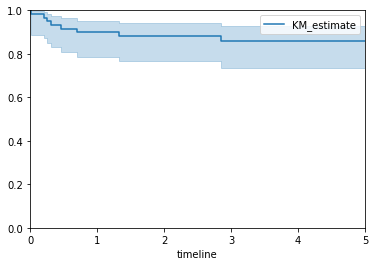

In [27]:
# old survival curve
old_surv = kmf.plot_survival_function()
old_surv.set_ylim(0,1)
old_surv.set_xlim(0,5)

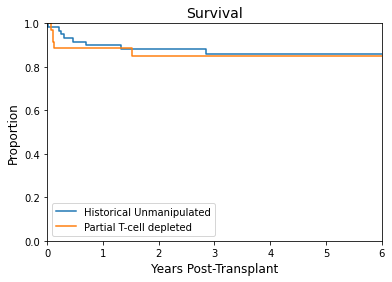

In [28]:
# survival curves
ax = plt.subplot(111)
kmf.fit(durations = T_old, event_observed = E_old, label = "Historical Unmanipulated")
kmf.plot(ax = ax, ci_show=False)
kmf.fit(T_new, event_observed = E_new, label = "Partial T-cell depleted")
kmf.plot(ax = ax, ci_show=False)
plt.title("Survival", fontsize=14)
plt.xlim(0,6)
plt.ylim(0,1)
plt.xlabel('Years Post-Transplant', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.savefig('5 year survival estimate', dpi=1200)


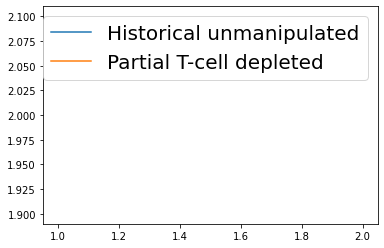

In [29]:
# make legend to crop
plt.figure('legend')
plt.plot(1,2)
plt.plot(2,2)
plt.legend(['Historical unmanipulated', 'Partial T-cell depleted'], fontsize=20)
plt.savefig('legend', dpi=1200)

plt.show()